# Fuel Efficiency Assignment
## Adapted from TensorFlow Tutorials
Using the [Boston Housing jupyter notebook](Boston_Housing_Example.ipynb) as an example follow the prompts below to build a neural network to predict vehicle fuel efficiency.

In [17]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_13250/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [18]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [19]:
# Download the dataset
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [20]:
# Add labels to columns and view dataset
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [21]:
# Vehicle origin needs to be encoded to factors.  
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [22]:
# Remove missing data
missing_idx = dataset[dataset.isnull().any(axis=1)].index
dataset.iloc[missing_idx]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
32,25.0,4,98.0,NaN,2046.0,19.0,71,1.0,0.0,0.0
126,21.0,6,200.0,NaN,2875.0,17.0,74,1.0,0.0,0.0
330,40.9,4,85.0,NaN,1835.0,17.3,80,0.0,1.0,0.0
336,23.6,4,140.0,NaN,2905.0,14.3,80,1.0,0.0,0.0
354,34.5,4,100.0,NaN,2320.0,15.8,81,0.0,1.0,0.0
374,23.0,4,151.0,NaN,3035.0,20.5,82,1.0,0.0,0.0


In [23]:
# Separate target to not use in imputation
target = dataset.pop('MPG')

# Impute missing data
imputer = KNNImputer()
dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=imputer.feature_names_in_)
dataset.iloc[missing_idx]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
32,4.0,98.0,62.0,2046.0,19.0,71.0,1.0,0.0,0.0
126,6.0,200.0,107.6,2875.0,17.0,74.0,1.0,0.0,0.0
330,4.0,85.0,58.2,1835.0,17.3,80.0,0.0,1.0,0.0
336,4.0,140.0,112.8,2905.0,14.3,80.0,1.0,0.0,0.0
354,4.0,100.0,80.8,2320.0,15.8,81.0,0.0,1.0,0.0
374,4.0,151.0,88.2,3035.0,20.5,82.0,1.0,0.0,0.0


In [24]:
# Normalize the data by subtracting the mean from each feature and divide by one standard deviation
scaler = StandardScaler()
X = scaler.fit_transform(dataset)
target_scaler = StandardScaler()
y = target_scaler.fit_transform(target.values.reshape(-1, 1))
list(zip([round(col.mean(),3) for col in X.T], [round(col.std(),3) for col in X.T]))

[(-0.0, 1.0),
 (-0.0, 1.0),
 (0.0, 1.0),
 (-0.0, 1.0),
 (-0.0, 1.0),
 (-0.0, 1.0),
 (0.0, 1.0),
 (-0.0, 1.0),
 (0.0, 1.0)]

In [25]:
# Split the dataset into training , validation, and testing sets

train_size = int(0.7 * dataset.shape[0])
val_size = int(0.2 * dataset.shape[0])
test_size = dataset.shape[0] - train_size - val_size

ds = tf.data.Dataset.from_tensor_slices((X, y))

ds = ds.shuffle(1000, reshuffle_each_iteration=False)

train_ds = ds.take(train_size).batch(32).prefetch(1)
remaining_ds = ds.skip(train_size)
val_ds = remaining_ds.take(val_size).batch(32).prefetch(1)
test_ds = remaining_ds.skip(test_size).batch(32).prefetch(1)

Processing the dataset like this sped up training 5x

In [26]:
# Built a sequential neural network model.  Start with backend.clear_session()
# Think about what activation function you will use, the input shape, number of nodes, and output shape and activation
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(9,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Compile the model.  Use 'rmsprop' optimizer.  Think about what loss function and metrics you need to use for a
# regression problem and add it below.
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449 (1.75 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Fit the model.  Use 1000 epochs.  Add a validation split to your model.  Set verbose = 0.
history = model.fit(train_ds, epochs=1000, validation_data=val_ds, verbose=0)

In [28]:
# Use this bit of code to view the History output.
hist = pd.DataFrame(history.history)
display(hist)

,loss,mae,val_loss,val_mae
0,0.963680,0.806810,0.908326,0.795499
1,0.702975,0.695645,0.737844,0.719838
2,0.566021,0.624376,0.612720,0.656850
3,0.464635,0.562693,0.507134,0.596411
4,0.383056,0.503958,0.420127,0.538628
...,...,...,...,...
995,0.026917,0.116581,0.159589,0.283082
996,0.027188,0.117220,0.159945,0.283746
997,0.026883,0.115514,0.160007,0.283777
998,0.026948,0.116592,0.160019,0.283468


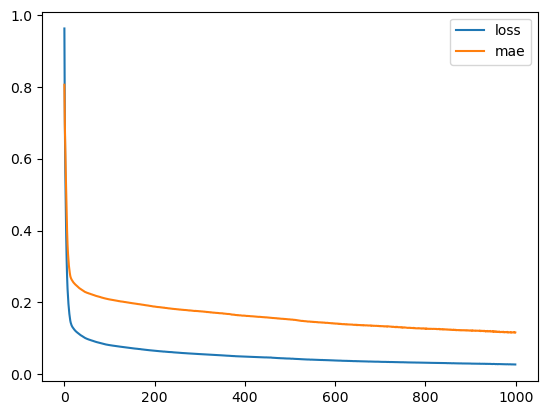

In [29]:
#Get the loss and MAE vs epochs
plt.plot(hist['loss'], label='loss')
plt.plot(hist['mae'], label='mae')
plt.legend()
plt.show()

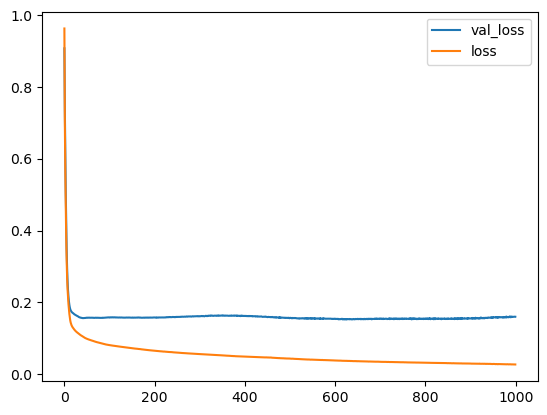

In [30]:
# Use the Boston Housing example to plot the validation and training loss vs epochs
plt.plot(hist['val_loss'], label='val_loss')
plt.plot(hist['loss'], label='loss')
plt.legend()
plt.show()

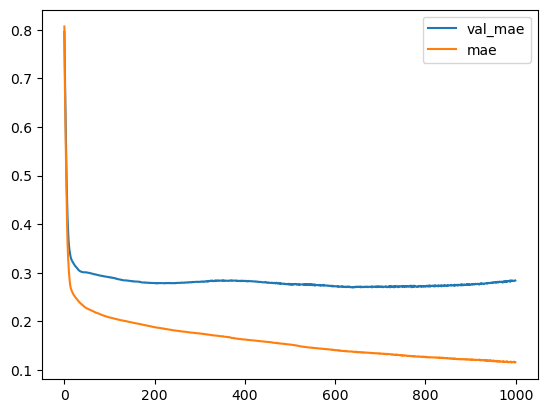

In [31]:
# Use the Boston Housing example to plot the validation and training mean absolute error vs epochs
plt.plot(hist['val_mae'], label='val_mae')
plt.plot(hist['mae'], label='mae')
plt.legend()
plt.show()

In [32]:
# Evaluate the model on the test data and print the results
mse, mae = model.evaluate(test_ds)
print(f'Mean Squared Error: {(mse * target_scaler.scale_[0]**2):.2f}')
print(f'Mean Absolute Error: {mae * target_scaler.scale_[0]:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1218 - mae: 0.2752
Mean Squared Error: 6.91
Mean Absolute Error: 2.08


Build a new model and try to get the  accuracy as high as you can. Things to try: more hidden layers and hidden units, activation types, epochs, batch size, and validation_split. Try as many models as you like.  

Be sure to clear the session each time: `backend.clear_session()`. Copy your best model at the end of the notebook.

In [40]:
tf.keras.backend.clear_session()

import keras_tuner as kt

def model_builder(hp):
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=4)
    n_units = hp.Int('n_units', min_value=8, max_value=128, step=2, sampling='log')
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5)
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate = learning_rate
    activation = hp.Choice('activation', values=['relu', 'leaky_relu'])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(9,)))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_units, activation=activation, kernel_initializer='he_normal'))
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

<div class="alert alert-block alert-warning">
<b>Warning:</b> Running the next cell will create a folder in your working directory and save results of the hyperparameter search
</div>

In [41]:
tuner = kt.BayesianOptimization(model_builder, objective='val_loss', max_trials=200, project_name='auto_mpg')
tuner.search(train_ds, epochs=1000, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True)])

Trial 200 Complete [00h 00m 05s]
val_loss: 0.16338488459587097

Best val_loss So Far: 0.11833764612674713
Total elapsed time: 02h 16m 09s


In [42]:
best_trial = tuner.oracle.get_best_trials()[0]
best_trial.summary()

Trial 104 summary
Hyperparameters:
n_hidden: 3
n_units: 64
learning_rate: 0.0036745168626475355
dropout: 0.10074584672209372
optimizer: rmsprop
activation: relu
Score: 0.11833764612674713


In [43]:
best_trial.best_step

37

In [48]:
best_model = tuner.get_best_models()[0]
mse, mae = best_model.evaluate(test_ds)
print(f'Mean Squared Error: {(mse * target_scaler.scale_[0]**2):.2f}')
print(f'Mean Absolute Error: {mae * target_scaler.scale_[0]:.2f}')

/home/chandon/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0929 - mae: 0.2428
Mean Squared Error: 5.93
Mean Absolute Error: 1.91
